# Neural Collaborative Filtering

In [18]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.models import Sequential, Model
from tensorflow.sparse import SparseTensor
import keras
from keras import layers
from keras import ops
import tensorflow as tf


In [19]:
%run "1.Recommendation_Loading.ipynb"

C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_1496\4069270214.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_recommended"] = df["is_recommended"].apply(lambda x: 1 if x == True else 0)
C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_1496\4069270214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id_categorical'] = pd.Categorical(df['user_id']).codes
C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_1496\4069270214.py:7: SettingWithCopyWarning: 
A value is trying to be se

## Data Preparation

### Filtering For Users and Games

In [4]:
def users_at_least_k_recs(df, K, n_users):
    """
    Return a list of users who perform at least K recommendations. Also, filtering for n_users randomòy selected
    Args::
        df: dataframe, recommendation dataset
        K: integer, representing the minimum number of recommendations for a user to be included in the final list
        n_users: integer, number of randomly selected users
    Return:
        users: a list of randomly selected users who perform at least K recommendations
    """
    series = df.groupby("user_id_categorical")["user_id_categorical"].count()>=K
    series1 = series[series]
    users = list(series1.index)
    return np.random.choice(users, size = n_users)

users_to_keep = users_at_least_k_recs(recommendations, 20, 5000)
print("Number of users",  '{0:,.0f}'.format(len(users_to_keep)))
print("First five users id", users_to_keep[:5])


Number of users 5,000
First five users id [ 6825220  7106371  3861248 10734526    76129]


### Loading the matrix and Apply Filtering

In [5]:
# LOADING THE MATRIX
# Due to the large memory requirements, the user-game matrix has been created in the notebook "User-Games Matrix - Building"
with open("matrix/user_game_matrix.pkl", 'rb') as file:
    user_game_matrix = pickle.load(file)

# Convert this array/matrix to Dictionary Of Keys format
# user_game_matrix = user_game_matrix.todok()
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix.size))


Number of Rows: 12,663,134
Numbeer of Columns: 37,420
Number of stored values: 47,967,516


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_1496\173573044.py:4: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  user_game_matrix = pickle.load(file)


In [6]:
# FILTERING the MATRIX for USERS to KEEP
# Matrix with only the subset of users who did at least k recs
mask = np.isin(np.array(user_game_matrix[:,0].todense()).reshape(-1), users_to_keep)
user_game_matrix_k_rec = user_game_matrix[mask]
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix_k_rec.size))
user_game_matrix_k_rec

Number of Rows: 4,922
Numbeer of Columns: 37,420
Number of stored values: 193,991


<4922x37420 sparse matrix of type '<class 'numpy.int32'>'
	with 193991 stored elements in Compressed Sparse Column format>

In [7]:
# INSERTING a GAME ID ROW to the user-game matrix
games_id = np.arange(0, user_game_matrix_k_rec.shape[1]).reshape(1,-1)
games_id = sp.sparse.csc_matrix(games_id)
user_game_matrix_k_rec = sp.sparse.vstack((games_id, user_game_matrix_k_rec))
user_game_matrix_k_rec.todense()


matrix([[       0,        1,        2, ...,    37417,    37418,    37419],
        [    1083,        0,        0, ...,        0,        0,        0],
        [    3860,        0,        0, ...,        0,        0,        0],
        ...,
        [12653104,        0,        0, ...,        0,        0,        0],
        [12653143,        0,        0, ...,        0,        0,        0],
        [12657971,        0,        0, ...,        0,        0,        0]])

In [8]:
# dropping games with no recommendations
mask = list(np.array(np.sum(user_game_matrix_k_rec[1:,1:], axis=0)>=1).reshape(-1))
mask.insert(0,True)
user_game_matrix_k_rec = user_game_matrix_k_rec.T[mask].T
print("Number of Rows:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[0]))
print("Numbeer of Columns:", '{0:,.0f}'.format(user_game_matrix_k_rec.shape[1]))
print("Number of stored values:", '{0:,.0f}'.format(user_game_matrix_k_rec.size))
user_game_matrix_k_rec.todense()

Number of Rows: 4,923
Numbeer of Columns: 17,354
Number of stored values: 211,344


matrix([[       0,        1,        2, ...,    37394,    37398,    37399],
        [    1083,        0,        0, ...,        0,        0,        0],
        [    3860,        0,        0, ...,        0,        0,        0],
        ...,
        [12653104,        0,        0, ...,        0,        0,        0],
        [12653143,        0,        0, ...,        0,        0,        0],
        [12657971,        0,        0, ...,        0,        0,        0]])

In [9]:
# GAMES MAPPING 
# keys: integer, starting from 1 which are the columns of the filtered matrix
# values: original app_id_categorical
all_games = np.array(user_game_matrix_k_rec[0,1:].todense()).reshape(-1)
games_mapping = {k:i for k,i in enumerate(all_games)}
swapped_games_dict = {v: k for k, v in games_mapping.items()}
# swapped_games_dict[3481]

In [10]:
# USERS mapping
users_to_keep = np.array(user_game_matrix_k_rec[1:,0].todense()).reshape(-1)
users_mapping = {k:i for k,i in enumerate(users_to_keep)}
swapped_users_dict = {v: k for k, v in users_mapping.items()}


In [11]:
def build_recommendations_sample(df):
    # recommendations_sample = df[(df["user_id_categorical"].isin(users_to_keep)) & (df["app_id_categorical"].isin(games_to_keep))]
    recommendations_sample = df[(df["user_id_categorical"].isin(users_to_keep))]
    return recommendations_sample

recommendations_sample = build_recommendations_sample(recommendations)
# recommendations_sample[recommendations_sample["user_id_categorical"]==731702]


### Train Test Split

### Test Set

In [12]:
# def get_test_instances(test):
def get_test_instances(df):
    """
    This functions generates test instances using the Leave One Out Approach taking the maximum recommendation date
    """
    max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()
    rec_df = pd.merge(df, max_df, left_on=["user_id_categorical","date"], right_on=["user_id_categorical","date"])
    rec_df["user_id_categorical_new"] = rec_df["user_id_categorical"].map(swapped_users_dict)
    rec_df["app_id_categorical_new"] = rec_df["app_id_categorical"].map(swapped_games_dict)
    x_test = rec_df[["user_id_categorical_new", "app_id_categorical_new"]].values
    y_test = np.full((x_test.shape[0],1), 1)
    return x_test, y_test

x_test, y_test = get_test_instances(recommendations_sample)
print("x_test.shape",  x_test.shape)
print("y_test.shape",  y_test.shape)


x_test.shape (6426, 2)
y_test.shape (6426, 1)


C:\Users\riccardoricci\AppData\Local\Temp\ipykernel_1496\3121204030.py:6: FutureWarning: The provided callable <function nanmax at 0x000001C1751ACAF0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_df = df.groupby("user_id_categorical").agg({"date": np.nanmax}).reset_index()


In [13]:
x_test_dict = dict(x_test)

### Get Training Istances

Including negative samples

In [14]:
train = user_game_matrix_k_rec[1:,1:].todok()
num_users, num_items = train.shape
print("Numbeer of Users:", '{0:,.0f}'.format(num_users))
print("Number of Games:", '{0:,.0f}'.format(num_items))


Numbeer of Users: 4,922
Number of Games: 17,353


In [15]:
def get_train_instances(train, num_negatives):
    """
    This functions generates training instances. For each user in the training data,
    I should have users who recommended games and users who do not recommend games
    """
    user_input, item_input, labels = [],[],[]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        item_selected = [] # to avoid duplicates
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while ((u, j) in train.keys()) or ((u,j) in item_selected) or ((u,j) in x_test_dict.keys()):
                j = np.random.randint(num_items)
               # print("user:", u)
               #  print("game:", j)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
            item_selected.append((u,j))
        
    p = np.vstack([user_input, item_input, labels]).T
    p = np.unique(p, axis=0)
    x_train = p[:,:2]
    y_train = p[:, 2].reshape(-1, 1) # np.array(labels).reshape(1,-1).T
    return x_train, y_train

x_train, y_train = get_train_instances(train, 4)
print("x_train.shape",  x_train.shape)
print("y_train.shape",  x_train.shape)


x_train.shape (937886, 2)
y_train.shape (937886, 2)


## Create the model

In [16]:
# EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    # def __init__(self, num_users, num_items, embedding_size, num_units_layers=[64,32],  **kwargs):
    def __init__(self, num_users, num_items, num_units_layers,  **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        # embeddings reduce the dimensionality, they are like look up tables
        # self.embedding_size = embedding_size
        self.user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
        self.item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.user_bias = layers.Embedding(num_users, 1)
        
        self.game_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim= int(num_units_layers[0]/2), # embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # self.game_bias = layers.Embedding(num_items, 1)

        # 
        self.flatten_users = layers.Flatten()
        self.flatten_games = layers.Flatten()
        self.concat_users_games = layers.Concatenate()
        self.dense_layer_1 = layers.Dense(
            units = num_units_layers[0],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.dense_layer_2 = layers.Dense(
            units = num_units_layers[1],
            activation = "relu",
            kernel_initializer="glorot_uniform"
        )
        self.prediction = layers.Dense(
            units = 1,
            activation = "sigmoid",
            input_dim = num_units_layers[1]
        )


    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        # user_bias = self.user_bias(inputs[:,0])
        game_vector = self.game_embedding(inputs[:,1])
        # game_bias = self.game_bias(inputs[:,1])
        # dot_user_game = ops.tensordot(user_vector, game_vector, 2)
        # x = dot_user_game + user_bias + game_bias
        users_flat = self.flatten_users(user_vector)
        # print(users_flat.shape)
        games_flat = self.flatten_games(game_vector)
        concat = self.concat_users_games([users_flat, games_flat])
        dense_layer_1 = self.dense_layer_1(concat)
        dense_layer_2 = self.dense_layer_2(dense_layer_1)
        prediction = self.prediction(dense_layer_2)
        # return ops.nn.softmax(prediction)    
        # return ops.nn.sigmoid(x)
        return prediction # ops.nn.sigmoid(prediction)


# model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model = RecommenderNet(num_users, num_items, [20,10])
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adagrad is suited for sparse data
    # metrics=['accuracy']
)

c:\Users\riccardoricci\.conda\envs\NCF\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history = model.fit(
    x=x_train, # user_idx and app_idx
    y=y_train, # recommendations, always 1
    #batch_size=64, # Number of samples per gradient update aka Minibatch Gradient Descent
    epochs=10, # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
    verbose=1, # progress line
    validation_data=(x_test, y_test) # Data on which to evaluate the loss and any model metrics at the end of each epoch
    
)

Epoch 1/10
29309/29309 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.3532 - val_loss: 0.9834
Epoch 2/10
22936/29309 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.3116

KeyboardInterrupt: 

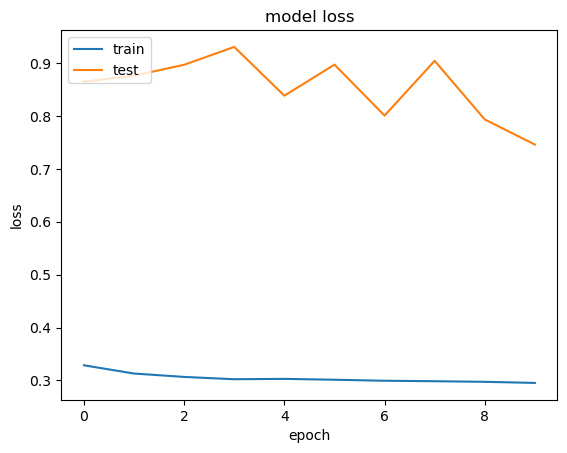

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
K = 100

In [ ]:
%run "Model_Evaluation.ipynb"

591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
K 100
Number of users: 4925
Average Precision 0
Average Precision 0
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate the model

In [ ]:
def get_random_userid():
    # pick 1 random user in the training data at random
    user_id_eval = np.random.randint(num_users)
    # user_id_eval_df = users_mapping[user_id_eval]
    return user_id_eval

user_id_eval = get_random_userid()
user_id_eval

2800

In [ ]:
K = 10

In [ ]:
def get_y_true(user_id):
    # Stacking x_train and y_train
    y_true_tmp = np.hstack((x_train, y_train))
    # keep only the recommended games
    y_true_tmp = y_true_tmp[y_true_tmp[:,-1] == 1]
    # filtering for the user id
    y_true = y_true_tmp[y_true_tmp[:,0] == user_id][:,1]
    return y_true
    
y_true = get_y_true(user_id_eval)
y_true

array([   19,    20,   724,  1231,  1331,  1347,  1459,  1551,  1899,
        2009,  2156,  2264,  2307,  4271,  6635,  6712,  6739,  9013,
       10739, 12824, 14127, 14243, 14252, 14264, 14942, 17637, 17638,
       17800])

In [ ]:
def get_user_games(user_id):
    # Generate a list of all games for a specific user
    games = list(games_mapping.keys())
    games2pred = np.reshape(games, (-1,1))
    user_game_array_eval = np.hstack(([[user_id]] * len(games), games2pred))
    return user_game_array_eval

user_games = get_user_games(user_id_eval)
user_games

array([[ 2800,     0],
       [ 2800,     1],
       [ 2800,     2],
       ...,
       [ 2800, 18889],
       [ 2800, 18890],
       [ 2800, 18891]])

In [ ]:
def get_y_pred(user_games_array, k):
    preds = model.predict(user_games_array)
    user_games_preds = np.hstack((user_games_array, preds))
    sorted_indices = np.argsort(-user_games_preds[:, -1])
    y_pred = user_games_preds[sorted_indices][:k, :]
    y_pred = y_pred[:,1].astype('int32')
    return y_pred

y_pred = get_y_pred(user_games, K)
y_pred

591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


array([  412, 12824,  3999,  4048, 11343,  1143,  1468,  3953,  1166,
         212])

In [ ]:
def eval_k(y_true, y_pred):
    items_relevant_user = len(y_true)
    rec_items_relevant = len(set(y_true).intersection(set(y_pred)))
    recall = rec_items_relevant / items_relevant_user
    precision = rec_items_relevant / K
    return recall, precision

eval_k(y_true, y_pred) 

(0.03571428571428571, 0.1)

In [ ]:
def eval_k_avg(n_users, K):
    precision = []
    recall = []
    for i in range(n_users):
        user_id_eval = get_random_userid()
        y_true = get_y_true(user_id_eval)
        user_games = get_user_games(user_id_eval)
        y_pred = get_y_pred(user_games, K)
        rcl, prc = eval_k(y_true, y_pred)
        precision.append(prc)
        recall.append(rcl)
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    return avg_precision, avg_recall

eval_k_avg(10, 5)

591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


(0.030000000000000006, 0.008292282430213464)

In [ ]:
x_test

array([[    0,  4927],
       [    1, 14542],
       [    2,  5279],
       ...,
       [ 4924, 12546],
       [ 4924,  4577],
       [ 4924, 13942]], dtype=int64)

In [ ]:
def eval_hit_ratio(K, n_users):
    counter = 0
    for user_game in x_test[:n_users,:]:
        user_games = get_user_games(user_game[0])
        y_pred = get_y_pred(user_games, K)
        if(user_game[1] in y_pred):
            counter += 1
    return counter / n_users

eval_hit_ratio(30, 30)

548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
548/548 ━━━━━━━━━━━━━

0.06666666666666667

In [ ]:
# user_game_array_eval = recommendations_sample[recommendations_sample["user_id_categorical"]==user_id_eval_df][["user_id_categorical", "app_id_categorical"]].values
# print("User", user_id_eval_df, "( corresponding to integer id",user_id_eval, ")" , "recommended these games (first 5 entries)")
# print(user_game_array_eval[:5])
# # List of only the games
# games_rec_eval = user_game_array_eval[:,1]
# print("The user", user_id_eval_df,   "recommended", len(games_rec_eval), "games")